In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras import datasets 
from tensorflow.keras import layers 
from tensorflow.keras import initializers 
from tensorflow.keras import regularizers 
from tensorflow.keras import losses, optimizers, metrics
from tensorflow.keras import callbacks 
from tensorflow.keras.models import Sequential

import activationsf

In [2]:
# Check tf version
!python -c 'import tensorflow as tf; print(tf.__version__)' 

2020-05-22 08:41:01.276101: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2.3.0-dev20200521


In [3]:
# Load CIFAR10 
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train/ 255.0, x_test/ 255.0

In [5]:
# Wrap using tf.data for better performane
train = tf.data.Dataset.from_tensor_slices((x_train, y_train))

In [6]:
# Set Early Stopping
es = callbacks.EarlyStopping(
        monitor='val_accuracy',
        # "no longer improving" being defined as "no increase greater or equal than 1e-2"
        min_delta=5e-3,
        patience=5,
        mode='max', 
        verbose=1)

In [7]:
# plot diagnostic learning curves
def summarize_diagnostics(history, fine_tuning=False):
	
	if fine_tuning :
		color_train = 'green'
		color_validation = 'red'
	else :
		color_train = 'blue'
		color_validation = 'orange'

	# plot loss
	plt.subplot(211)
	plt.title('Cross Entropy Loss')
	plt.plot(history.history['loss'], color=color_train, label='train')
	plt.plot(history.history['val_loss'], color=color_validation, label='test')
	# plot accuracy
	plt.subplot(212)
	plt.title('Classification Accuracy')
	plt.plot(history.history['accuracy'], color=color_train, label='train')
	plt.plot(history.history['val_accuracy'], color=color_validation, label='test')
	# save plot to file
	plt.savefig('plot.png')

In [0]:
elu_cnn = Sequential([
  
  # VGG inspired model: 
  layers.Conv2D(32, 3, padding='same', activation='elu', kernel_initializer='he_uniform',  input_shape = (32, 32, 3)),
  layers.BatchNormalization(),
  layers.Conv2D(32, 3, padding='same', activation='elu', kernel_initializer='he_uniform'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Dropout(0.2, seed=42),

  layers.Conv2D(64, 3, padding='same', activation='elu', kernel_initializer='he_uniform'),
  layers.BatchNormalization(),
  layers.Conv2D(64, 3, padding='same', activation='elu', kernel_initializer='he_uniform'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Dropout(0.3, seed=42),

  layers.Conv2D(128, 3, padding='same', activation='elu', kernel_initializer='he_uniform'),
  layers.BatchNormalization(),
  layers.Conv2D(128, 3, padding='same', activation='elu', kernel_initializer='he_uniform'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Dropout(0.4, seed=42),

  tf.keras.layers.GlobalAveragePooling2D(),
  layers.Dense(128, activation='elu', kernel_regularizer=regularizers.l2(0.0012)),
  layers.Dropout(0.5, seed=42),
  layers.Dense(10, activation='softmax', kernel_regularizer=regularizers.l2(0.0012))
])

elu_cnn.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
  
elu_cnn.summary()

print('\n Training \n')
history_elu = elu_cnn.fit(x = x_train, y = y_train, batch_size = 64, epochs=20, validation_data=(x_test, y_test), callbacks=[es])

summarize_diagnostics(history_elu)

print('\n Model Evaluation \n')
elu_cnn.evaluate(x = x_test, y = y_test, batch_size=64)

print('\n Save the Model \n')
elu_cnn.save('saved_custom_model/elu_cnn') 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        1

In [0]:
# Define round with decimal precision in tf
def my_tf_round(x, decimals = 0):
    multiplier = tf.constant(10**decimals, dtype=x.dtype)
    return tf.round(x * multiplier) / multiplier

In [0]:
class incremental_learning_withDecreasing_ratio(tf.keras.callbacks.Callback):
    """ Icrementally adjust the KWTA ratio every 2 epochs. 
        End the learning process when ratio == 0.2 """

    def __init__(self, delta = 0.01):
        super(incremental_learning_withDecreasing_ratio, self).__init__()
        self.delta = delta

    def on_epoch_begin(self, epoch, logs=None):
        # The update occurs at the beginning of every 2 epochs
        if epoch % 2 == 0: 
            for i in range(1, 8): # For each kwta layer. TODO: architecture dependent implementation, not so elegant
                name = 'kwta_'+str(i)
                layer = self.model.get_layer(name = name)
                layer.ratio.assign_sub(self.delta)
            
            print('\n Fine tuning: current ratio {:.2f} \n'.format(layer.ratio.numpy()))
    
    def on_epoch_end(self, epoch, logs=None):
        layer = self.model.get_layer('kwta_1')
        if ( my_tf_round(layer.ratio, 2) == 0.15 ) and epoch % 2 == 1: 
                print('\n Desired Ratio reached, stop training...')
                self.model.stop_training = True

In [6]:
kwta_cnn = Sequential([
  
  # Same architecture, use KWTA instead of ELU
  layers.Conv2D(32, 3, padding='same', activation=None, kernel_initializer='he_uniform',  input_shape = (32, 32, 3)),
  layers.BatchNormalization(),
  Kwta(ratio=0.30, conv=True, name='kwta_1'),
  layers.Conv2D(32, 3, padding='same', activation=None, kernel_initializer='he_uniform'),
  layers.BatchNormalization(),
  Kwta(ratio=0.30, conv=True, name='kwta_2'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Dropout(0.2, seed=42),

  layers.Conv2D(64, 3, padding='same', activation=None, kernel_initializer='he_uniform'),
  layers.BatchNormalization(),
  Kwta(ratio=0.30, conv=True, name='kwta_3'),
  layers.Conv2D(64, 3, padding='same', activation=None, kernel_initializer='he_uniform'),
  layers.BatchNormalization(),
  Kwta(ratio=0.30, conv=True, name='kwta_4'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Dropout(0.30, seed=42),

  layers.Conv2D(128, 3, padding='same', activation=None, kernel_initializer='he_uniform'),
  layers.BatchNormalization(),
  Kwta(ratio=0.30, conv=True, name='kwta_5'),
  layers.Conv2D(128, 3, padding='same', activation=None, kernel_initializer='he_uniform'),
  layers.BatchNormalization(),
  Kwta(ratio=0.30, conv=True, name='kwta_6'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Dropout(0.4, seed=42),

  layers.GlobalAveragePooling2D(),
  layers.Dense(128, activation=None, kernel_regularizer=regularizers.l2(0.0012)),
  Kwta(ratio=0.30, name='kwta_7'),
  layers.Dropout(0.5, seed=42),
  layers.Dense(10, activation='softmax', kernel_regularizer=regularizers.l2(0.0012))
  
])

kwta_cnn.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])


kwta_cnn.summary()

print('\n Train with ratio 0.30 until convergence \n')
history_kwta_es = kwta_cnn.fit(train.shuffle(1000).batch(32), epochs = 50, validation_data=(x_test, y_test), callbacks=[es])
summarize_diagnostics(history_kwta_es)

print('\n Fine tune learned weights until ratio is equal to 0.15 \n')
history_kwta_ft = kwta_cnn.fit(x=x_train, y=y_train, batch_size=64, epochs = 30, validation_data=(x_test, y_test), callbacks=[incremental_learning_withDecreasing_ratio()])
summarize_diagnostics(history_kwta_ft, fine_tuning=True)

print('\n Model Evaluation \n')
kwta_cnn.evaluate(x = x_test, y = y_test, batch_size=64)

print('\n Save the Model \n')
kwta_cnn.save('saved_custom_model/kwta_cnn') 

NameError: ignored

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_6 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
kaf_1 (Kaf)                  (None, 32, 32, 32)        330       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
kaf_2 (Kaf)                  (None, 32, 32, 32)        330       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)       

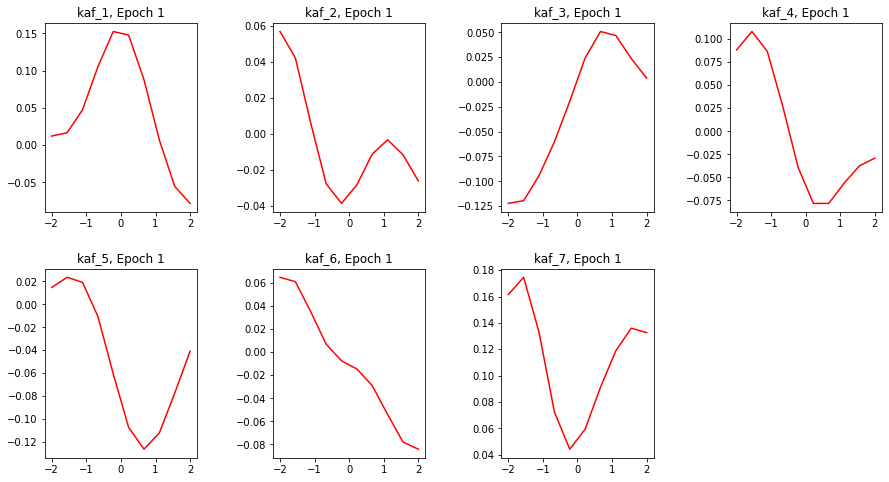

Epoch 1/20
  68/1563 [>.............................] - ETA: 4:00 - loss: 2.4235 - accuracy: 0.0970

KeyboardInterrupt: 

In [9]:
# Might speed up training casting computation to tf.float16.
tf.keras.mixed_precision.experimental.set_policy('mixed_float16')

kaf_cnn = Sequential([
  
  # Using KAFs instead
  layers.Conv2D(32, 3, padding='same', activation=None, kernel_initializer='he_uniform',  input_shape = (32, 32, 3)),
  layers.BatchNormalization(),
  activationsf.Kaf(conv=True, D=10, name='kaf_1'),
  layers.Conv2D(32, 3, padding='same', activation=None, kernel_initializer='he_uniform'),
  layers.BatchNormalization(),
  activationsf.Kaf(conv=True, D=10, name='kaf_2'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Dropout(0.2, seed=42),

  layers.Conv2D(64, 3, padding='same', activation=None, kernel_initializer='he_uniform'),
  layers.BatchNormalization(),
  activationsf.Kaf(conv=True, D=10, name='kaf_3'),
  layers.Conv2D(64, 3, padding='same', activation=None, kernel_initializer='he_uniform'),
  layers.BatchNormalization(),
  activationsf.Kaf(conv=True, D=10, name='kaf_4'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Dropout(0.3, seed=42),

  layers.Conv2D(128, 3, padding='same', activation=None, kernel_initializer='he_uniform'),
  layers.BatchNormalization(),
  activationsf.Kaf(conv=True, D=10, name='kaf_5'),
  layers.Conv2D(128, 3, padding='same', activation=None, kernel_initializer='he_uniform'),
  layers.BatchNormalization(),
  activationsf.Kaf(conv=True, D=10, name='kaf_6'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Dropout(0.4, seed=42),

  layers.GlobalAveragePooling2D(),
  layers.Dense(128, activation=None, kernel_regularizer=regularizers.l2(0.0012)),
  activationsf.Kaf(D=10, name='kaf_7'),
  layers.Dropout(0.5, seed=42),
  layers.Dense(10, activation='softmax', kernel_regularizer=regularizers.l2(0.0012), dtype=tf.float32)
])

kaf_cnn.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

kaf_cnn.summary()

# Train until convergence
history_kaf = kaf_cnn.fit(train.shuffle(1000).batch(32), epochs = 20, validation_data=(x_test, y_test), callbacks=[es, activationsf.plot_kafs_epoch_wise(num_layers=7)])
summarize_diagnostics(history_kaf)

kaf_cnn.evaluate(x = x_test, y = y_test, batch_size=32)

# Save kaf_cnn
kaf_cnn.save('saved_custom_model/kaf_cnn')


In [7]:
elukaf_cnn = Sequential([
  
  # Using KAFs ELU-Ridge initialized
  layers.Conv2D(32, 3, padding='same', activation=None, kernel_initializer='he_uniform',  input_shape = (32, 32, 3)),
  layers.BatchNormalization(),
  Kaf(conv=True, D=20, ridge='elu'),
  layers.Conv2D(32, 3, padding='same', activation=None, kernel_initializer='he_uniform'),
  layers.BatchNormalization(),
  Kaf(conv=True, D=20, ridge='elu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Dropout(0.2, seed=42),

  layers.Conv2D(64, 3, padding='same', activation=None, kernel_initializer='he_uniform'),
  layers.BatchNormalization(),
  Kaf(conv=True, D=20, ridge='elu'),
  layers.Conv2D(64, 3, padding='same', activation=None, kernel_initializer='he_uniform'),
  layers.BatchNormalization(),
  Kaf(conv=True, D=20, ridge='elu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Dropout(0.3, seed=42),

  layers.Conv2D(128, 3, padding='same', activation=None, kernel_initializer='he_uniform'),
  layers.BatchNormalization(),
  Kaf(conv=True, D=20, ridge='elu'),
  layers.Conv2D(128, 3, padding='same', activation=None, kernel_initializer='he_uniform'),
  layers.BatchNormalization(),
  Kaf(conv=True, D=20, ridge='elu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Dropout(0.4, seed=42),

  layers.GlobalAveragePooling2D(),
  layers.Dense(256, activation=None, kernel_regularizer=regularizers.l2(0.0012)),
  Kaf(D=20, ridge='elu'),
  layers.Dropout(0.5, seed=42),
  layers.Dense(10, activation='softmax', kernel_regularizer=regularizers.l2(0.0012))
])

elukaf_cnn.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

elukaf_cnn.summary()

# Train until convergence
history_kaf = elukaf_cnn.fit(train.shuffle(500).batch(32), epochs = 20, validation_data=(x_test, y_test), callbacks=[es])
summarize_diagnostics(history_kaf)

elukaf_cnn.evaluate(x = x_test, y = y_test, batch_size=32)

# Save elukaf_cnn
elukaf_cnn.save('saved_custom_model/elukaf_cnn')


NameError: ignored